In [ ]:
# author: Jana Lasser

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
from os.path import join
from PIL import Image

In [24]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "sans-serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

In [25]:
# colors
demblue = "#0015BC"
repred = "#FF0000"
indgrey = "#696969"
demgrey = "#9EA4BF"
repgrey = "#BF9EA2"

In [26]:
dst = "../../plots"
src = "../../data"

# Main

## Fig 1: scattertext & topics

In [27]:
# load the topic data
fname = "topics_per_class.csv"
topics = pd.read_csv(join(src, "tweets", fname))

# extract the topics of interest
chosen_topics = [2, 3, 4, 7, 12, 13, 15, 19, 20, 21, 29,
          39, 45, 52, 104, 116, 142, 163, 218, 331]
topics = topics[topics["Topic"].isin(chosen_topics)]
topics = topics.sort_values(by="Topic")

# beautify the topic name strings
topics["Name"] = topics["Name"].apply(lambda x: x.split("_"))
topics["Name"] = topics["Name"].apply(lambda x: " $\\vert$ ".join(x[1:]))

# add a column with party information
topics["Party"] = np.nan
topics.loc[topics[topics["Class"].str.startswith("r")].index, "Party"] = "Republican"
topics.loc[topics[topics["Class"].str.startswith("d")].index, "Party"] = "Democrat"

# add a column with honesty component information
topics["Component"] = np.nan
topics.loc[topics[topics["Class"].str.endswith("b")].index, "Component"] = "belief-speaking"
topics.loc[topics[topics["Class"].str.endswith("t")].index, "Component"] = "truth-seeking"
topics.loc[topics[topics["Class"].str.endswith("o")].index, "Component"] = "other"

topics = topics.drop(columns=["Class", "Words"]).reset_index(drop=True)
topics.head(2)

,Topic,Frequency,Name,Party,Component
0,2,4994,abortion $\vert$ woman $\vert$ right $\vert$ life,Republican,other
1,2,7031,abortion $\vert$ woman $\vert$ right $\vert$ life,Democrat,other


In [29]:
# calculate within-topic frequencies for norming
N_topic = topics[["Topic", "Frequency"]]\
    .groupby(["Topic"])\
    .sum()

# calculate within-topic within-party frequencies for norming
N_topic_party = topics[["Topic", "Party", "Frequency"]]\
    .groupby(["Topic", "Party"])\
    .sum()

In [30]:
N_topic_party.head(4)

Frequency
Topic Party                
2     Democrat         8485
      Republican       6291
3     Democrat        11259
      Republican       1448

In [31]:
# calculate within-topic within-component within-party frequencies 
components = ["belief-speaking", "truth-seeking"]
agg = topics[topics["Component"].isin(components)]\
    [["Topic", "Party", "Component", "Frequency"]]\
    .groupby(["Topic", "Party", "Component"])\
    .sum()
# norm frequencies by within-topic within-party frequencies
agg["Frequency_norm"] = agg["Frequency"] / N_topic_party["Frequency"] * 100
agg.head(4)

Frequency  Frequency_norm
Topic Party      Component                                 
2     Democrat   belief-speaking        606        7.142015
                 truth-seeking          848        9.994107
      Republican belief-speaking        593        9.426164
                 truth-seeking          704       11.190590

In [32]:
# calculate within-topic within-component frequencies normed by within-topic
# frequencies
agg2 = topics[topics["Component"].isin(components)]\
    [["Topic", "Component", "Frequency"]]\
    .groupby(["Topic", "Component"])\
    .sum()
agg2["Frequency_norm"] = agg2["Frequency"] / N_topic["Frequency"] * 100
agg2.head(4)

Frequency  Frequency_norm
Topic Component                                 
2     belief-speaking       1199        8.114510
      truth-seeking         1552       10.503519
3     belief-speaking        746        5.870780
      truth-seeking         1426       11.222161

In [33]:
# add centered frequencies by subtracting within-topic within-component
# frequencies from within-topic within-component within-party frequencies
agg = agg.reset_index()
agg = agg.set_index(["Topic", "Component", "Party"])
agg["Frequency_norm_centered"] = agg["Frequency_norm"] - agg2["Frequency_norm"]
agg = agg.reset_index()
del agg2
agg.head(4)

,Topic,Component,Party,Frequency,Frequency_norm,Frequency_norm_centered
0,2,belief-speaking,Democrat,606,7.142015,-0.972495
1,2,truth-seeking,Democrat,848,9.994107,-0.509412
2,2,belief-speaking,Republican,593,9.426164,1.311654
3,2,truth-seeking,Republican,704,11.190590,0.687071


In [34]:
# add topic names for plotting
names = topics[["Topic", "Name"]].drop_duplicates()
agg = agg.reset_index()
agg = pd.merge(agg, names, how="left", left_on="Topic", right_on="Topic")

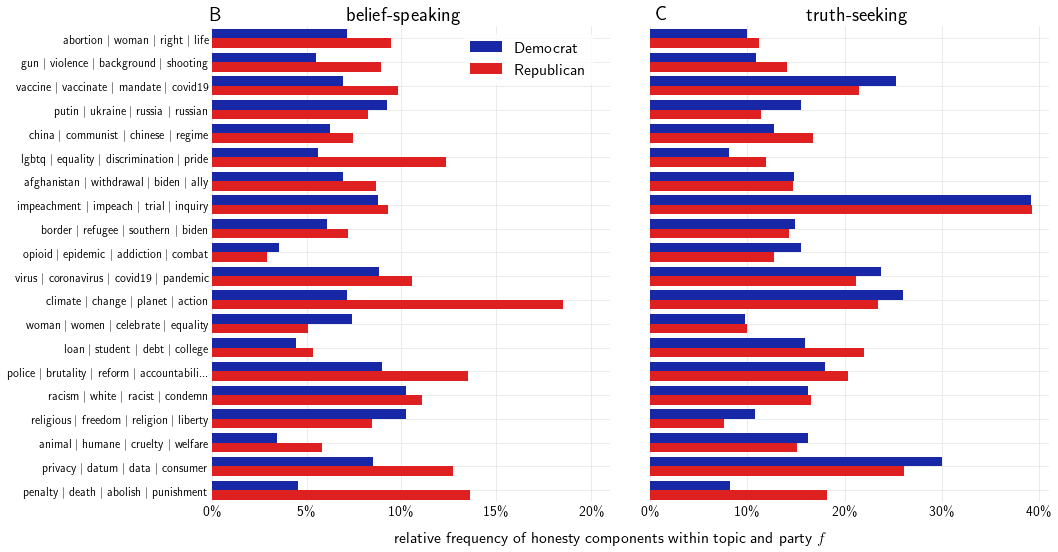

In [54]:
# set up figure and subplots
fname = "fig1b"
fig = plt.figure(figsize=(15, 8.75))
gs = GridSpec(7, 2, figure=fig, hspace=0.8, wspace=0.1)
ax1 = fig.add_subplot(gs[0:, 0])
ax2 = fig.add_subplot(gs[0:, 1])
axes = [ax1, ax2]

# belief-speaking
sns.barplot(x="Frequency_norm", 
            y="Name",
            hue="Party",
            data=agg[agg["Component"] == "belief-speaking"],
            ax=axes[0],
            palette=[demblue, repred], 
            hue_order=["Democrat", "Republican"],
            zorder=3)
# truth-seeking
sns.barplot(x="Frequency_norm", 
            y="Name",
            hue="Party",
            data=agg[agg["Component"] == "truth-seeking"],
            ax=axes[1],
            palette=[demblue, repred], 
            hue_order=["Democrat", "Republican"],
            zorder=3)

# axis labels, ticks, annotations and grids
ax1.tick_params(axis='y', labelsize=12)

ax2.set_xlabel("")
ax2.legend_.remove()
ax1.set_xlabel("relative frequency of honesty components within topic and party $f$", fontsize=16)

ax1.xaxis.set_label_coords(1, -0.06)
legend = ax1.legend(loc=1, bbox_to_anchor=[0.975, 1.0, 0, 0], fontsize=16)
legend.get_frame().set_facecolor((1, 1, 1, 1))
legend.get_frame().set_edgecolor((1, 1, 1, 1))

 
ax1.set_xlim(0, 21)
ax1.set_xticks(range(0, 21, 5))
ax1.set_xticklabels([f"{i}\%" for i in range(0, 21, 5)], fontsize=14)
ax2.set_xlim(0, 41)
ax2.set_xticks(range(0, 41, 10))
ax2.set_xticklabels([f"{i}\%" for i in range(0, 41, 10)], fontsize=14)

ax2.set_yticklabels([])
    
for ax in axes:
    ax.set_ylabel("")
    ax.grid(which="both", zorder=1, color=(230/255, 230/255, 230/255))
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
fig.text(0.123, 0.89, "B", fontsize=20)
fig.text(0.25, 0.89, "belief-speaking", fontsize=20)
fig.text(0.536, 0.89, "C", fontsize=20)
fig.text(0.675, 0.89, "truth-seeking", fontsize=20)

plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 2: honesty component timelines

In [37]:
fname = "US_politician_accounts_2010-11-06_to_2022-03-16.csv"
users = pd.read_csv(join(src, "users", fname))

In [17]:
fname = "belief.csv"
belief_bootstrap = pd.read_csv(join(src, "bootstrapping", fname))

belief = belief_bootstrap[["year", "month", "belief_share", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", "std"])
belief = belief.reset_index()
belief.columns = ["year", "month", "party", "belief_mean", "belief_std"]

In [18]:
fname = "truth.csv"
truth_bootstrap = pd.read_csv(join(src, "bootstrapping", fname))

truth = truth_bootstrap[["year", "month", "truth_share", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", "std"])
truth = truth.reset_index()
truth.columns = ["year", "month", "party", "truth_mean", "truth_std"]

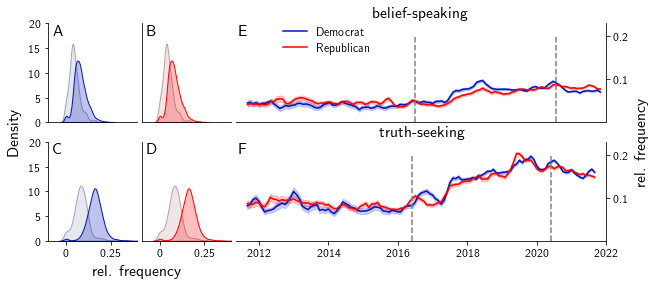

In [19]:
fname = "fig2"
cutoff = 2011
fig = plt.figure(figsize=(10, 4))

gs = GridSpec(2, 6, figure=fig, hspace=0.2, wspace=0.05)
ax1 = fig.add_subplot(gs[0, 2:])
ax2 = fig.add_subplot(gs[1, 2:])
ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[0, 1])
ax6 = fig.add_subplot(gs[1, 1])

# timelines
for ax, df, label, title in zip([ax1, ax2], [belief, truth], 
                    ["belief", "truth"], ["belief-speaking", "truth-seeking"]):
    for party, color in zip(["Democrat", "Republican"], [demblue, repred]):
        subset = df[(df["year"] > cutoff) & (df["party"] == party)].copy()
        ax.plot(range(len(subset)), subset[label + "_mean"].rolling(3).mean(),
                color=color, label=party)
        ax.fill_between(range(len(subset)), 
                         subset[label + "_mean"].rolling(3).mean(),
                         subset[label + "_mean"].rolling(3).mean() + subset[label + "_std"].rolling(3).mean(),
                         color=color, alpha=0.2)
        ax.fill_between(range(len(subset)), 
                         subset[label + "_mean"].rolling(3).mean(),
                         subset[label + "_mean"].rolling(3).mean() - subset[label + "_std"].rolling(3).mean(),
                         color=color, alpha=0.2)

    ax.set_ylim(0, 0.23)
    ax.set_xlim(-2, 124)
    ax.set_yticks([0.1, 0.2])
    ax.set_yticklabels([0.1, 0.2], fontsize=12)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(title, fontsize=16)
    ax.plot([59, 59], [0, 0.2], "--", color="grey")
    ax.plot([107, 107], [0, 0.2], "--", color="grey")
    
    if label == "truth":
        ax.set_xticks([6, 30, 54, 78, 102, 126])
        ax.set_xticklabels(["2012", "2014", "2016", "2018", "2020", "2022"],
                           fontsize=12)
    else:
        ax.set_xticks([])
        ax.legend(loc=2, fontsize=12, bbox_to_anchor=[0.1, 1.08, 0, 0], frameon=False)
        
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if label == "belief":
        ax.set_ylabel(f"rel. frequency", fontsize=16)
        ax.yaxis.set_label_coords(1.075, -0.2)

    
# marginal distributions
subset = users[users["party"].isin(["Democrat", "Republican"])].copy()

axes_grid = np.asarray([[ax3, ax5], [ax4, ax6]])
for row, label, i in zip(["belief_share", "truth_share"],
                ["belief speaking", "truth seeking"], range(2)):
    axes = axes_grid[i, 0:]
    
    for party, ax, j in zip(["Democrat", "Republican"], axes, range(2)):
        legend = False
        palette1 = {"Democrat":demgrey, "Republican":repgrey}
        palette2 = {"Democrat":demblue, "Republican":repred}
        if row == "belief_share": legend = True
        sns.kdeplot(data=subset, x=row + "_2010_to_2013", alpha=0.25,
                    color=palette1[party], fill=True, ax=ax, legend=False)
        sns.kdeplot(data=subset, x=row + "_2019_to_2022", 
                    color=palette2[party], fill=True, ax=ax, legend=False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if party == "Republican": 
            ax.set_ylabel("")
            ax.set_yticks([])
        else:
            ax.set_yticks([0, 5, 10, 15, 20])
            ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=12)
            if row == "belief_share":
                ax.set_ylabel("Density", fontsize=16)
                ax.yaxis.set_label_coords(-0.3, -0.1)
            else:
                ax.set_ylabel("")
        ax.set_xlim(-0.1, 0.4)
        ax.set_ylim(0, 20)
        
        if row == "belief_share":
            ax.set_xticks([])
            ax.set_xlabel("")
        else:
            ax.set_xticks([0, 0.25])
            ax.set_xticklabels([0, 0.25], fontsize=12)
            if party == "Democrat":
                ax.set_xlabel("rel. frequency", fontsize=16)
                ax.xaxis.set_label_coords(1, -0.23)
            else:
                ax.set_xlabel("")
fig.text(0.132, 0.84, "A", fontsize=16)
fig.text(0.132, 0.43, "C", fontsize=16)
fig.text(0.262, 0.84, "B", fontsize=16)
fig.text(0.262, 0.43, "D", fontsize=16)
fig.text(0.39, 0.84, "E", fontsize=16)
fig.text(0.39, 0.43, "F", fontsize=16)

plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 3: misinformation scatter & prediction

In [20]:
fname = "US_politician_accounts_2010-11-06_to_2022-03-16.csv"
users = pd.read_csv(join(src, "users", fname))

In [21]:
fname = "OLS_predictions_score.csv"
predictions = pd.read_csv(join(src, "users", fname))
user_belief_pred_dem = predictions[(predictions["party"] == "Democrat") &\
                              (predictions["honesty_component"] == "belief")]
user_belief_pred_rep = predictions[(predictions["party"] == "Republican") &\
                              (predictions["honesty_component"] == "belief")]
user_truth_pred_dem = predictions[(predictions["party"] == "Democrat") &\
                              (predictions["honesty_component"] == "truth")]
user_truth_pred_rep = predictions[(predictions["party"] == "Republican") &\
                              (predictions["honesty_component"] == "truth")]

In [22]:
fname = "article_scores_with_parties.csv.gzip"
articles = pd.read_csv(join(src, "articles", fname), compression="gzip")

In [23]:
fname = "OLS_predictions_articles.csv"
predictions = pd.read_csv(join(src, "articles", fname))
article_belief_pred_dem = predictions[(predictions["party"] == "Democrat") &\
                              (predictions["honesty_component"] == "belief")]
article_belief_pred_rep = predictions[(predictions["party"] == "Republican") &\
                              (predictions["honesty_component"] == "belief")]
article_truth_pred_dem = predictions[(predictions["party"] == "Democrat") &\
                              (predictions["honesty_component"] == "truth")]
article_truth_pred_rep = predictions[(predictions["party"] == "Republican") &\
                              (predictions["honesty_component"] == "truth")]

In [24]:
def plot_kernel_density_y(ax, data, ycol, bw_adjust=1, ylims=[60, 100]):
    parties = ["Democrat", "Republican"]
    sns.kdeplot(data=data[data["party"].isin(parties)], bw_adjust=bw_adjust,
                y=ycol, hue="party", alpha=0.25, hue_order=parties,
                palette=[demblue, repred], fill=True, ax=ax, legend=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim(ylims[0], ylims[1])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [25]:
def plot_kernel_density_x(ax, data, xcol, xlims):
    parties = ["Democrat", "Republican"]
    sns.kdeplot(data=data[data["party"].isin(parties)], 
                x=xcol, hue="party", alpha=0.25, hue_order=parties,
                palette=[demblue, repred], fill=True, ax=ax, legend=False)
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [26]:
def plot_scatter(ax, data, xcol, ycol):
    parties = ["Democrat", "Republican"]
    colors = [demblue, repred]
    for party, color in zip(parties, colors):
        subset = data[data["party"] == party]
        ax.scatter(subset[xcol], subset[ycol], color=color, alpha=0.1)

In [27]:
def plot_prediction(ax, preds, x, xlabel, 
                    xlims=[-0.01, 0.41],
                    xticks=[0, 0.1, 0.2, 0.3, 0.4],
                    ylims=[58, 102],
                    yticks=[60, 70, 80, 90, 100]):
    parties = ["Democrat", "Republican"]
    colors = [demblue, repred]    
    for pred, color, party in zip(preds, colors, parties):
        pred = pred.iloc[0:len(honesty_component_share)]
        ax.plot(x, pred["mean"], color=color, label=party)
        ax.fill_between(x, pred["mean"], pred["mean_ci_lower"], 
                        alpha=0.2, color=color)
        ax.fill_between(x, pred["mean"], pred["mean_ci_upper"], 
                        alpha=0.2, color=color)

    ax.set_ylim(ylims[0], ylims[1])
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{tick * 100:1.0f}\%" for tick in xticks], fontsize=12)

In [28]:
def test_yaxis_margin_plot(ax, y):
    ax.plot([0.01, 0.01], y)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])

In [29]:
def test_xaxis_margin_plot(ax, x):
    ax.plot(x, [10, 10])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])

In [30]:
articles_sample = articles.sample(frac=0.05, random_state=42).copy()
jitter = np.asarray([np.random.rand() for i in range(len(articles_sample))])
jitter = (jitter - 0.5) * 3
articles_sample["NG_score"] = articles_sample["NG_score"] + jitter

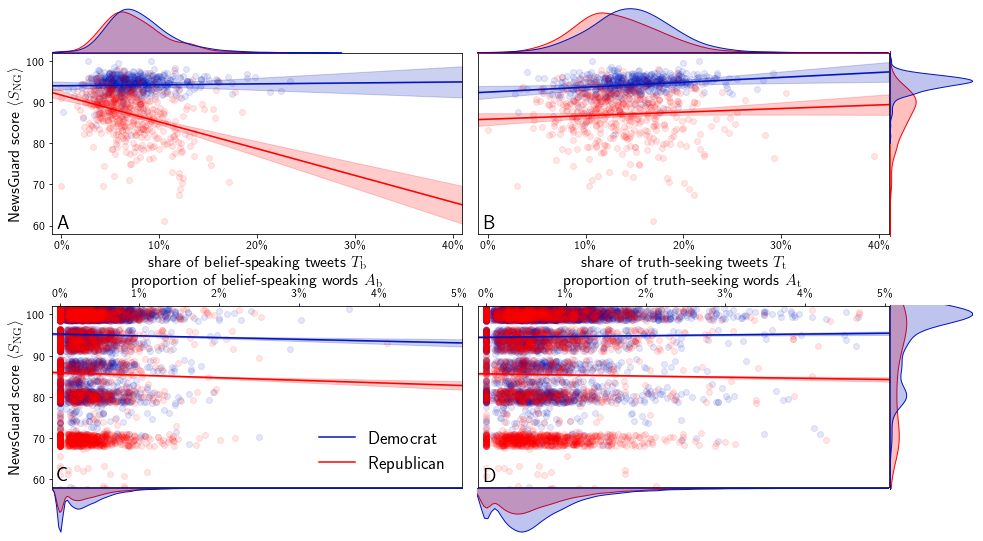

In [31]:
fname = "fig3"
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(2, 18, figure=fig, hspace=0.4, wspace=0.5)
ax0 = fig.add_subplot(gs[0, 0:9])
ax1 = fig.add_subplot(gs[0, 9:])
ax2 = fig.add_subplot(gs[1, 0:9])
ax3 = fig.add_subplot(gs[1, 9:])

# user scatter
plot_scatter(ax0, users, "belief_share", "NG_score_mean")
plot_scatter(ax1, users, "truth_share", "NG_score_mean")

# article scatter
plot_scatter(ax2, articles_sample, "belief_prop", "NG_score")
plot_scatter(ax3, articles_sample, "truth_prop", "NG_score")

# user predicted NewsGuard score
honesty_component_share = np.arange(-0.01, 0.42, 0.01)
plot_prediction(
    ax0,
    (user_belief_pred_dem, user_belief_pred_rep),
    honesty_component_share, 
    "share of belief-speaking tweets $T_\\mathrm{b}$",
)
plot_prediction(
    ax1,
    (user_truth_pred_dem, user_truth_pred_rep),
    honesty_component_share, 
    "share of truth-seeking tweets $T_\\mathrm{t}$",
)

# article predicted NewsGuard score
honesty_component_share = np.arange(-0.002, 0.12, 0.001)
plot_prediction(
    ax2,
    (article_belief_pred_dem, article_belief_pred_rep),
    honesty_component_share, 
    "proportion of belief-speaking words $A_\\mathrm{b}$",
    xlims=[-0.001, 0.0505],
    xticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
    ylims=[58, 102],
    yticks=range(60, 101, 10)
    #ylims=[0, 102],
    #yticks=range(0, 101, 20)
)
plot_prediction(
    ax3,
    (article_truth_pred_dem, article_truth_pred_rep),
    honesty_component_share, 
    "proportion of truth-seeking words $A_\\mathrm{t}$",
    xlims=[-0.001, 0.0505],
    xticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05],
    ylims=[58, 102],
    yticks=range(60, 101, 10)
    #ylims=[0, 102],
    #yticks=range(0, 101, 20)
)
     
width = 0.415
height = 0.32
    
# user score kernel density plot
rect = [0.901, 0.562, 0.08, height]
ax_hist1 = fig.add_axes(rect)
#test_yaxis_margin_plot(ax_hist1, [58, 102])
plot_kernel_density_y(ax_hist1, users, "NG_score_mean", ylims=[58, 102])

# article score kernel density plot
rect = [0.901, 0.122, 0.08, height]
ax_hist2 = fig.add_axes(rect)
#test_yaxis_margin_plot(ax_hist2, [58, 102])
plot_kernel_density_y(ax_hist2, articles, "NG_score", bw_adjust=3, ylims=[58, 102])

# user belief share kernel density plot
bottom = ax0.get_position().get_points()[1][1]
rect = [0.125, bottom, 0.415, 0.08]
ax_hist3 = fig.add_axes(rect)
#test_xaxis_margin_plot(ax_hist3, [-0.01, 0.41])
plot_kernel_density_x(ax_hist3, users, "belief_share", xlims=[-0.01, 0.41])

# user truth share kernel density plot
bottom = ax1.get_position().get_points()[1][1]
rect = [0.519, bottom, 0.38, 0.08]
ax_hist4 = fig.add_axes(rect)
#test_xaxis_margin_plot(ax_hist4, [-0.01, 0.41])
plot_kernel_density_x(ax_hist4, users, "truth_share", xlims=[-0.01, 0.41])

# article belief proportion kernel density plot
rect = [0.125, 0.0445, 0.38, 0.08]
ax_hist5 = fig.add_axes(rect)
ax_hist5.invert_yaxis()
#test_xaxis_margin_plot(ax_hist5, [-0.0025, 0.0505])
plot_kernel_density_x(ax_hist5, articles, "belief_prop", xlims=[-0.001, 0.0505])

# article truth proportion kernel density plot
rect = [0.519, 0.0445, 0.38, 0.08]
ax_hist6 = fig.add_axes(rect)
ax_hist6.invert_yaxis()
#test_xaxis_margin_plot(ax_hist6, [-0.0025, 0.0505])
plot_kernel_density_x(ax_hist6, articles, "truth_prop", xlims=[-0.001, 0.0505])

# label and tick beautification
for ax in [ax2, ax3]:
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    
for ax in [ax1, ax3]:
    ax.set_yticks([])

for ax in [ax0, ax2]:
    ax.set_ylabel("NewsGuard score $\\left< S_\\mathrm{NG}\\right>$", fontsize=16)

ax2.legend(loc=5, fontsize=18, bbox_to_anchor=[1, 0.2, 0, 0], frameon=False)
fig.text(0.13, 0.575, "A", fontsize=20)
fig.text(0.525, 0.575, "B", fontsize=20)
fig.text(0.13, 0.135, "C", fontsize=20)
fig.text(0.525, 0.135, "D", fontsize=20)

plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

# Extended data

## Fig 2: LIWC timelines

In [32]:
src = "../../data/bootstrapping"

In [33]:
fname = "LIWC"
LIWC_bootstrap = pd.read_csv(join(src, fname + ".csv"))
fname = "LIWC_belief"
LIWC_belief_bootstrap = pd.read_csv(join(src, fname + ".csv"))
fname = "LIWC_truth"
LIWC_truth_bootstrap = pd.read_csv(join(src, fname + ".csv"))
fname = "LIWC_neutral"
LIWC_neutral_bootstrap = pd.read_csv(join(src, fname + ".csv"))

In [34]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [35]:
cols = ["LIWC_analytic_share", "LIWC_authentic_share", "LIWC_moral_share",
        "LIWC_emo_pos_share", "LIWC_emo_neg_share"]
LIWC = LIWC_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_belief = LIWC_belief_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_truth = LIWC_truth_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_neutral = LIWC_neutral_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()

In [36]:
def plot_component(ax, component, component_title, baseline, col, ylim, window=3):
    dem = component[component["party"] == "Democrat"].copy()
    rep = component[component["party"] == "Republican"].copy()
    
    dem_bl = baseline[baseline["party"] == "Democrat"]
    rep_bl = baseline[baseline["party"] == "Republican"]
    

    dem_avg = dem[col]["mean"].rolling(window).mean().values /\
        dem_bl[col]["mean"].rolling(window).mean().values
    dem_lo = dem[col]["percentile_2.5"].rolling(window).mean().values /\
        dem_bl[col]["percentile_2.5"].rolling(window).mean().values
    dem_hi = dem[col]["percentile_97.5"].rolling(window).mean().values /\
        dem_bl[col]["percentile_97.5"].rolling(window).mean().values
    rep_avg = rep[col]["mean"].rolling(window).mean().values /\
        rep_bl[col]["mean"].rolling(window).mean().values
    rep_lo = rep[col]["percentile_2.5"].rolling(window).mean().values /\
        rep_bl[col]["percentile_2.5"].rolling(window).mean().values
    rep_hi = rep[col]["percentile_97.5"].rolling(window).mean().values /\
        rep_bl[col]["percentile_97.5"].rolling(window).mean().values
    
    ax.plot(range(len(dem)), dem_avg, color=demblue)
    ax.fill_between(range(len(dem)), dem_avg, dem_lo,
                    color=demblue, alpha=alpha)
    ax.fill_between(range(len(dem)), dem_avg, dem_hi,
                    color=demblue, alpha=alpha)
    
    ax.plot(range(len(rep)), rep_avg, color=repred)
    ax.fill_between(range(len(rep)), rep_avg, rep_lo,
                    color=repred, alpha=alpha)
    ax.fill_between(range(len(rep)), rep_avg, rep_hi,
                    color=repred, alpha=alpha)
    
    ax.set_xticks([])
    ax.set_xlim(-1, len(dem) + 5)
    ax.set_ylim(ylim[0], ylim[1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='y', labelsize=16)
    
    ax.text(len(dem) + 2, 
            ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.5,
            component_title.replace("-", "-\n"), rotation=90, ha="center", va="center")
    
    # add election dates
    ax.plot([74, 74], [ax.get_ylim()[0], ax.get_ylim()[1]], '--', color = "k")
    ax.plot([122, 122], [ax.get_ylim()[0], ax.get_ylim()[1]], '--', color = "k")
    
    # indicate baseline
    ax.plot([-1, len(dem) -1 ], [1, 1], '--', color="k")

In [37]:
def plot_baseline(ax, baseline, col, window=3):
    dem = baseline[baseline["party"] == "Democrat"]
    rep = baseline[baseline["party"] == "Republican"]
    dem_avg = dem[col]["mean"]
    dem_lo = dem[col]["percentile_2.5"]
    dem_hi = dem[col]["percentile_97.5"]
    rep_avg = rep[col]["mean"]
    rep_lo = rep[col]["percentile_2.5"]
    rep_hi = rep[col]["percentile_97.5"]
    
    ax.plot(range(len(dem)), dem_avg, color=demblue)
    ax.fill_between(range(len(dem)), dem_avg, dem_lo,
                    color=demblue, alpha=alpha)
    ax.fill_between(range(len(dem)), dem_avg, dem_hi,
                    color=demblue, alpha=alpha)
    
    ax.plot(range(len(dem)), rep_avg, color=repred)
    ax.fill_between(range(len(dem)), rep_avg, rep_lo,
                    color=repred, alpha=alpha)
    ax.fill_between(range(len(dem)), rep_avg, rep_hi,
                    color=repred, alpha=alpha)
    
    ax.set_xticks(list(range(3, 12*12 + 1, 12)))
    ax.set_xticklabels(range(2011, 2023), fontsize=16)
    ax.set_xlim(-1, len(dem) + 5)
    ax.tick_params(axis='y', labelsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.text(len(dem) + 2, 
        ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.5,
        "baseline", rotation=90, ha="center", va="center")
    
    # add election dates
    ax.plot([74, 74], [ax.get_ylim()[0], ax.get_ylim()[1]], '--', color = "k")
    ax.plot([122, 122], [ax.get_ylim()[0], ax.get_ylim()[1]], '--', color = "k")

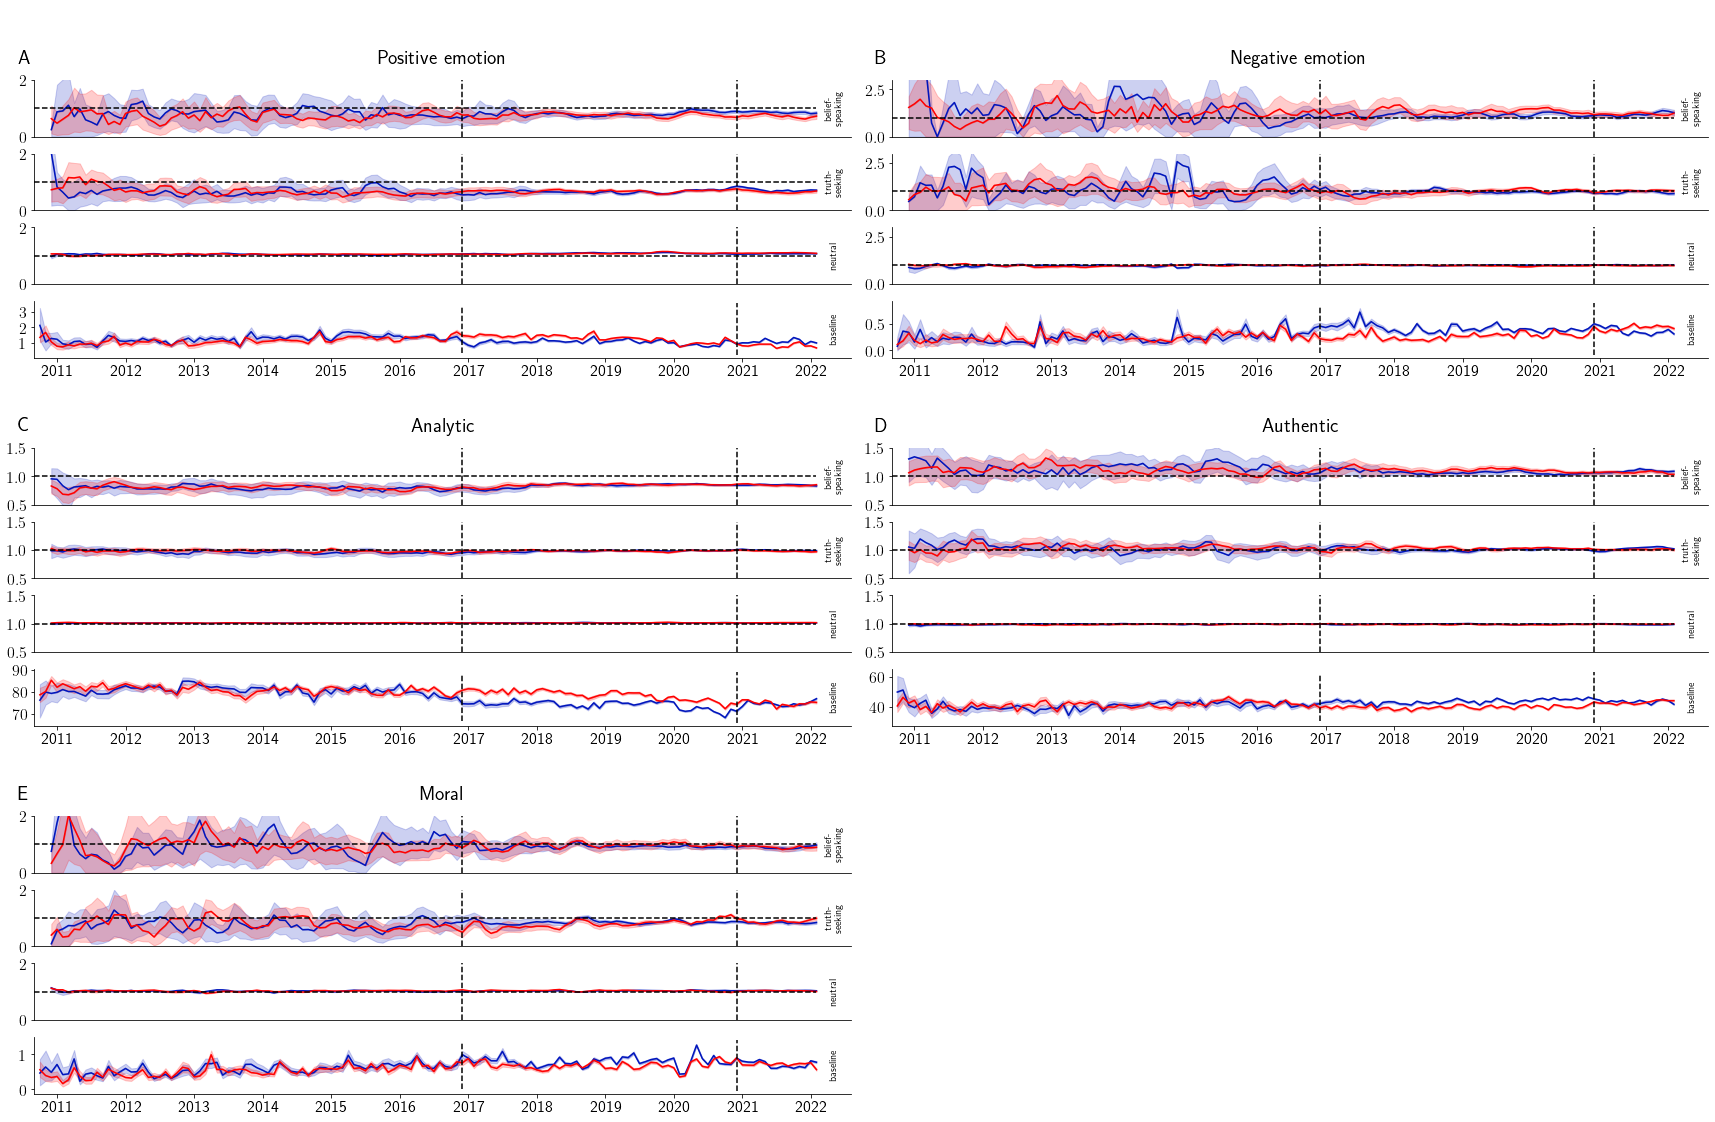

In [38]:
fname = "ext_fig2"
alpha = 0.2

fig = plt.figure(figsize=(30, 20))

gs = GridSpec(15, 2, figure=fig, hspace=0.3, wspace=0.05)
ax01 = fig.add_subplot(gs[1, 0])
ax02 = fig.add_subplot(gs[2, 0])
ax03 = fig.add_subplot(gs[3, 0])
ax04 = fig.add_subplot(gs[4, 0])

ax11 = fig.add_subplot(gs[1, 1])
ax12 = fig.add_subplot(gs[2, 1])
ax13 = fig.add_subplot(gs[3, 1])
ax14 = fig.add_subplot(gs[4, 1])

ax05 = fig.add_subplot(gs[6, 0])
ax06 = fig.add_subplot(gs[7, 0])
ax07 = fig.add_subplot(gs[8, 0])
ax08 = fig.add_subplot(gs[9, 0])

ax15 = fig.add_subplot(gs[6, 1])
ax16 = fig.add_subplot(gs[7, 1])
ax17 = fig.add_subplot(gs[8, 1])
ax18 = fig.add_subplot(gs[9, 1])

ax09 = fig.add_subplot(gs[11, 0])
ax010 = fig.add_subplot(gs[12, 0])
ax011 = fig.add_subplot(gs[13, 0])
ax012 = fig.add_subplot(gs[14, 0])

axt1 = fig.add_subplot(gs[0, 0])
axt2 = fig.add_subplot(gs[0, 1])
axt3 = fig.add_subplot(gs[5, 0])
axt4 = fig.add_subplot(gs[5, 1])
axt5 = fig.add_subplot(gs[10, 0])
 
data = {
    "belief-speaking":LIWC_belief,
    "truth-seeking":LIWC_truth,
    "neutral":LIWC_neutral,
    "baseline":LIWC
}

ylims = {
    "LIWC_emo_pos_share":[0, 2],
    "LIWC_emo_neg_share":[0, 3],
    "LIWC_analytic_share":[0.5, 1.5],
    "LIWC_authentic_share":[0.5, 1.5],
    "LIWC_moral_share":[0, 2]
}
    
for data_type, col, ax in zip(
    ["belief-speaking", "truth-seeking", "neutral", "baseline"] * 5,
    ["LIWC_emo_pos_share"] * 4 + ["LIWC_emo_neg_share"] * 4 + ["LIWC_analytic_share"] * 4 + \
    ["LIWC_authentic_share"] * 4 + ["LIWC_moral_share"] * 4,
    [ax01, ax02, ax03, ax04, ax11, ax12, ax13, ax14, ax05, ax06, ax07, ax08,
     ax15, ax16, ax17, ax18, ax09, ax010, ax011, ax012]
):
    
    if data_type in ["belief-speaking", "truth-seeking", "neutral"]:
        plot_component(ax, data[data_type], data_type, data["baseline"], col, 
                       ylims[col], window=3)
    else:
        plot_baseline(ax, data["baseline"], col, window=3)
    
for title, letter, ax in zip(
    ["Positive emotion", "Negative emotion", "Analytic", "Authentic", "Moral"],
    ["A", "B", "C", "D", "E"],
    [axt1, axt2, axt3, axt4, axt5]):
    
    ax.text(0.5, 0, title, fontsize=20, ha="center")
    ax.text(-0.02, 0, letter, fontsize=20, ha="left")
    ax.set_axis_off()

dst = "../../plots"
plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 3: coverage

In [39]:
src = "../../data/bootstrapping"

In [40]:
fname = "NG_coverage.csv"
coverage = pd.read_csv(join(src, fname))

In [41]:
coverage = coverage[["year", "month", "NG_coverage", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", "std"])
coverage = coverage.reset_index()
coverage.columns = ["year", "month", "party", "NG_coverage_mean", "NG_coverage_std"]

In [42]:
fname = "independent_coverage.csv"
independent_coverage = pd.read_csv(join(src, fname))

In [43]:
independent_coverage = independent_coverage\
    [["year", "month", "independent_coverage", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", "std"])
independent_coverage = independent_coverage.reset_index()
independent_coverage.columns = ["year", "month", "party", 
                    "independent_coverage_mean", "independent_coverage_std"]

In [44]:
def plot_coverage(ax, data, ycol, cutoff=2011):
    parties = ["Democrat", "Republican"]
    for party, color in zip(parties, [demblue, repred]):
        df = data[(data["year"] > cutoff) & (data["party"] == party)]
        ax.plot(range(len(df)), df[ycol + "_mean"], color=color, label=party)
        ax.fill_between(range(len(df)), 
                         df[ycol + "_mean"],
                         df[ycol + "_mean"] + df[ycol + "_std"],
                         color=color, alpha=0.2)
        ax.fill_between(range(len(df)), 
                         df[ycol + "_mean"],
                         df[ycol + "_mean"] - df[ycol + "_std"],
                         color=color, alpha=0.2)
        ax.set_ylim(0, 0.68)
        ax.set_yticks([0, 0.2, 0.4, 0.6])
        ax.set_yticklabels(["0%", "20%", "40%", "60%"], fontsize=12)

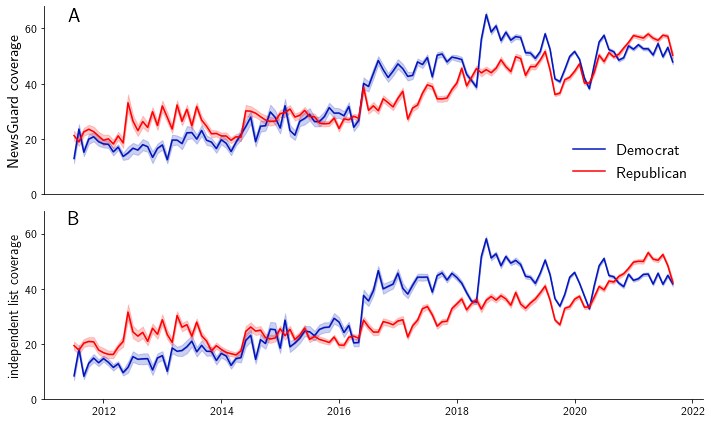

In [45]:
fname = "ext_fig3"
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_coverage(axes[0], coverage, "NG_coverage")
plot_coverage(axes[1], independent_coverage, "independent_coverage")

axes[0].set_xticks([])
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
axes[1].set_xticks(range(6, 131, 24))
axes[1].set_xticklabels(range(2012, 2023, 2), fontsize=12)
axes[0].legend(loc=4, fontsize=16, frameon=False)
axes[0].set_ylabel("NewsGuard coverage", fontsize=16)
axes[1].set_ylabel("independent list coverage", fontsize=14)
fig.tight_layout()
fig.text(0.1, 0.94, "A", fontsize=20)
fig.text(0.1, 0.47, "B", fontsize=20)
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 4: full article scatter

In [46]:
src = "../../data/articles"
fname = "article_scores_with_parties.csv.gzip"
articles = pd.read_csv(join(src, fname), compression="gzip")

In [47]:
jitter = np.asarray([np.random.rand() for i in range(len(articles))])
jitter = (jitter - 0.5) * 3
articles["NG_score"] = articles["NG_score"] + jitter

/tmp/ipykernel_608344/2453490869.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


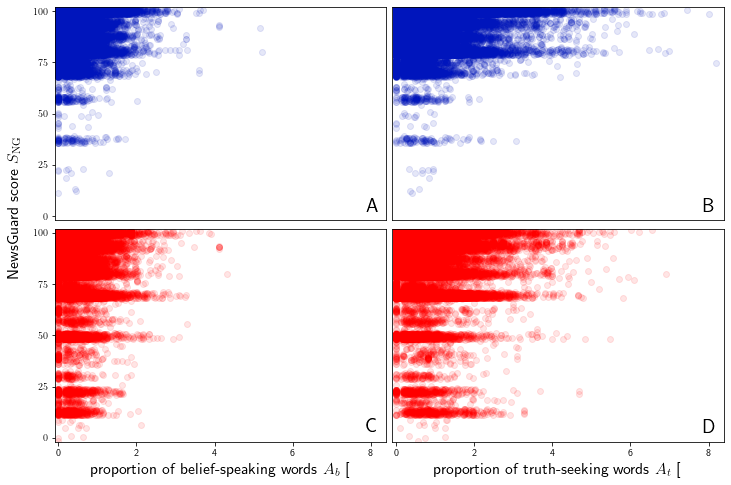

In [48]:
fname = "ext_fig4"
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 18, figure=fig, hspace=0.04, wspace=0.2)
ax0 = fig.add_subplot(gs[0, 0:9])
ax1 = fig.add_subplot(gs[0, 9:])
ax2 = fig.add_subplot(gs[1, 0:9])
ax3 = fig.add_subplot(gs[1, 9:])

# article scatter
dem = articles[articles["party"] == "Democrat"]
rep = articles[articles["party"] == "Republican"]

parties = ["Democrat", "Republican", "Democrat", "Republican"]
colors = [demblue, repred, demblue, repred]
ycols = ["belief_prop", "belief_prop", "truth_prop", "truth_prop"]
axes = [ax0, ax2, ax1, ax3]
for ax, xcol, party, color in zip(axes, ycols, parties, colors):
    subset = articles[articles["party"] == party]
    ax.scatter(subset[xcol], subset["NG_score"], color=color, alpha=0.1)
    ax.set_xlim(-0.001, 0.084)
    ax.set_ylim(-2, 102)
    
for ax in [ax1, ax3]:
    ax.set_yticks([])
for ax in [ax0, ax1]:
    ax.set_xticks([])
for ax in [ax2, ax3]:
    ax.set_xticks([0, 0.02, 0.04, 0.06, 0.08])
    ax.set_xticklabels([0, 2, 4, 6, 8])
for ax in [ax0, ax2]:
    ax.set_yticks([0, 25, 50, 75, 100])

ax2.set_ylabel("NewsGuard score $S_\mathrm{NG}$", fontsize=16)
ax2.yaxis.set_label_coords(-0.1, 1.1)
ax2.set_xlabel("proportion of belief-speaking words $A_b$ [%]", fontsize=16)
ax3.set_xlabel("proportion of truth-seeking words $A_t$ [%]", fontsize=16)

fig.text(0.485, 0.525, "A", fontsize=20)
fig.text(0.875, 0.525, "B", fontsize=20)
fig.text(0.485, 0.14, "C", fontsize=20)
fig.text(0.875, 0.14, "D", fontsize=20)
    
fig.tight_layout()
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".pdf"),bbox_inches="tight", facecolor="white")

# Supplementary Information

## Fig 1: Correlation between trustworthiness indicators

In [113]:
src = "../../data/bootstrapping"

In [114]:
fname = "user_reliability_score_correlations.csv"
pf_bootstrap = pd.read_csv(join(src, fname))

In [115]:
print("correlation NewsGuard Score with NewsGuard share: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_NGShare"].mean(),
        pf_bootstrap["corr_NGScore_NGShare"].quantile(0.025),
        pf_bootstrap["corr_NGScore_NGShare"].quantile(0.975),))

print("correlation NewsGuard Share with politifact: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGShare_pf"].mean(),
        pf_bootstrap["corr_NGShare_pf"].quantile(0.025),
        pf_bootstrap["corr_NGShare_pf"].quantile(0.975),))

print("correlation NewsGuard Share with independent list: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGShare_ind"].mean(),
        pf_bootstrap["corr_NGShare_ind"].quantile(0.025),
        pf_bootstrap["corr_NGShare_ind"].quantile(0.975),))

print("correlation NewsGuard Score with politifact: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_pf"].mean(),
        pf_bootstrap["corr_NGScore_pf"].quantile(0.025),
        pf_bootstrap["corr_NGScore_pf"].quantile(0.975),))

print("correlation independent list with politifact: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_ind_pf"].mean(),
        pf_bootstrap["corr_ind_pf"].quantile(0.025),
        pf_bootstrap["corr_ind_pf"].quantile(0.975),))

print("correlation NewsGuard Score with independent list: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_ind"].mean(),
        pf_bootstrap["corr_NGScore_ind"].quantile(0.025),
        pf_bootstrap["corr_NGScore_ind"].quantile(0.975),))

print("correlation NewsGuard Score with accuracy score: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_accuracy"].mean(),
        pf_bootstrap["corr_NGScore_accuracy"].quantile(0.025),
        pf_bootstrap["corr_NGScore_accuracy"].quantile(0.975),))

print("correlation NewsGuard Score with transparency score: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_transparency"].mean(),
        pf_bootstrap["corr_NGScore_transparency"].quantile(0.025),
        pf_bootstrap["corr_NGScore_transparency"].quantile(0.975),))

correlation NewsGuard Score with NewsGuard share: 0.7538 [0.7093; 0.7941]
correlation NewsGuard Share with politifact: 0.3712 [0.2736; 0.4642]
correlation NewsGuard Share with independent list: 0.8552 [0.8160; 0.8891]
correlation NewsGuard Score with politifact: 0.4374 [0.3453; 0.5226]
correlation independent list with politifact: 0.3780 [0.2709; 0.4752]
correlation NewsGuard Score with independent list: 0.8005 [0.7606; 0.8363]
correlation NewsGuard Score with accuracy score: 0.7355 [0.6928; 0.7749]
correlation NewsGuard Score with transparency score: 0.7617 [0.7203; 0.7984]


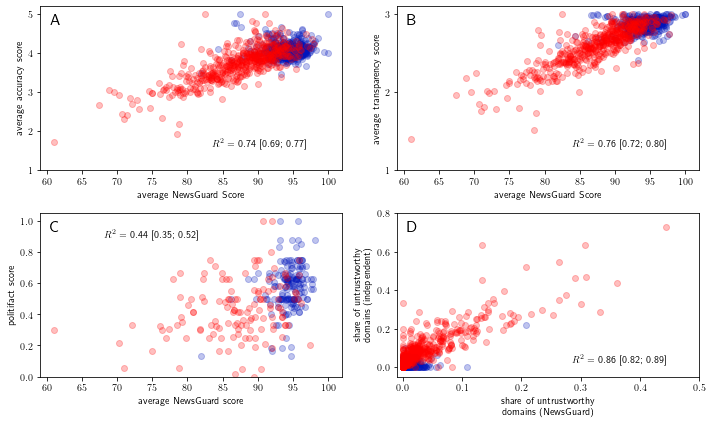

In [117]:
fname = "SI_fig1"
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
dem = users[users["party"] == "Democrat"]
rep = users[users["party"] == "Republican"]
ax = axes[0][0]
ax.scatter(dem["NG_score_mean"], dem["accuracy_mean"], color=demblue, alpha=0.25)
ax.scatter(rep["NG_score_mean"], rep["accuracy_mean"], color=repred, alpha=0.25)
ax.set_xlabel("average NewsGuard Score")
ax.set_ylabel("average accuracy score")
ax.set_xlim(59, 102)
ax.set_ylim(1, 5.2)
ax.set_yticks([1, 2, 3, 4, 5])

ax = axes[0][1]
ax.scatter(dem["NG_score_mean"], dem["transparency_mean"], color=demblue, alpha=0.25)
ax.scatter(rep["NG_score_mean"], rep["transparency_mean"], color=repred, alpha=0.25)
ax.set_xlabel("average NewsGuard Score")
ax.set_ylabel("average transparency score")
ax.set_xlim(59, 102)
ax.set_ylim(1, 3.1)
ax.set_yticks([1, 2, 3])

ax = axes[1][0]
ax.scatter(dem["NG_score_mean"], dem["pf_score"], color=demblue, alpha=0.25)
ax.scatter(rep["NG_score_mean"], rep["pf_score"], color=repred, alpha=0.25)
ax.set_xlabel("average NewsGuard score")
ax.set_ylabel("politifact score")
ax.set_xlim(59, 102)
ax.set_ylim(0, 1.05)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax = axes[1][1]
ax.scatter(dem["NG_unreliable_share"], dem["independent_unreliable_share"], color=demblue, alpha=0.25)
ax.scatter(rep["NG_unreliable_share"], rep["independent_unreliable_share"], color=repred, alpha=0.25)
ax.set_xlabel("share of untrustworthy\ndomains (NewsGuard)")
ax.set_ylabel("share of untrustworthy\ndomains (independent)")
ax.set_xlim(-0.01, 0.5)
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_ylim(-0.05, 0.8)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

fig.text(0.3, 0.65, "$R^2 =$ {:1.2f} [{:1.2f}; {:1.2f}]".format(\
        pf_bootstrap["corr_NGScore_accuracy"].mean(),
        pf_bootstrap["corr_NGScore_accuracy"].quantile(0.025),
        pf_bootstrap["corr_NGScore_accuracy"].quantile(0.975)))

fig.text(0.8, 0.65, "$R^2 =$ {:1.2f} [{:1.2f}; {:1.2f}]".format(\
        pf_bootstrap["corr_NGScore_transparency"].mean(),
        pf_bootstrap["corr_NGScore_transparency"].quantile(0.025),
        pf_bootstrap["corr_NGScore_transparency"].quantile(0.975)))

fig.text(0.15, 0.44, "$R^2 =$ {:1.2f} [{:1.2f}; {:1.2f}]".format(\
        pf_bootstrap["corr_NGScore_pf"].mean(),
        pf_bootstrap["corr_NGScore_pf"].quantile(0.025),
        pf_bootstrap["corr_NGScore_pf"].quantile(0.975)))

fig.text(0.8, 0.15, "$R^2 =$ {:1.2f} [{:1.2f}; {:1.2f}]".format(\
        pf_bootstrap["corr_NGShare_ind"].mean(),
        pf_bootstrap["corr_NGShare_ind"].quantile(0.025),
        pf_bootstrap["corr_NGShare_ind"].quantile(0.975)))

fig.text(0.075, 0.933, "A", fontsize=16)
fig.text(0.57, 0.933, "B", fontsize=16)
fig.text(0.075, 0.455, "C", fontsize=16)
fig.text(0.57, 0.455, "D", fontsize=16)

fig.tight_layout()
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".pdf"),bbox_inches="tight", facecolor="white")